In [183]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [184]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

cifar_transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)

Files already downloaded and verified


In [216]:
mnist_loader = DataLoader(mnist_dataset, batch_size=1, shuffle=True)
cifar_loader = DataLoader(cifar_dataset, batch_size=1, shuffle=True)

# Fetch one random sample from each dataset
mnist_image, _ = next(iter(mnist_loader))
cifar_image, _ = next(iter(cifar_loader))

# Verify dimensions
print("MNIST image shape:", mnist_image.shape)
print("CIFAR-10 image shape:", cifar_image.shape)

MNIST image shape: torch.Size([1, 3, 32, 32])
CIFAR-10 image shape: torch.Size([1, 3, 32, 32])


In [217]:
mean_image = (mnist_image + cifar_image) / 2.0
print("Mean image shape:", mean_image.shape)


Mean image shape: torch.Size([1, 3, 32, 32])


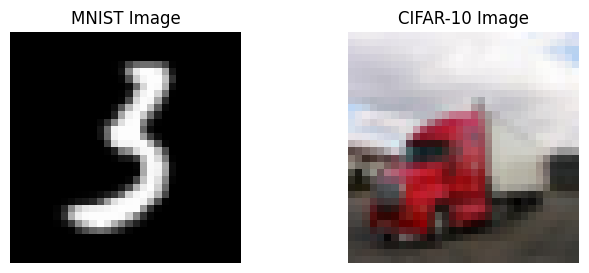

In [218]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 3))
mnist_image_np = mnist_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
cifar_image_np = cifar_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
mean_image_np = mean_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
plt.subplot(1, 2, 1)
plt.title('MNIST Image')
plt.imshow(mnist_image_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('CIFAR-10 Image')
plt.imshow(cifar_image_np)
plt.axis('off')

plt.show()

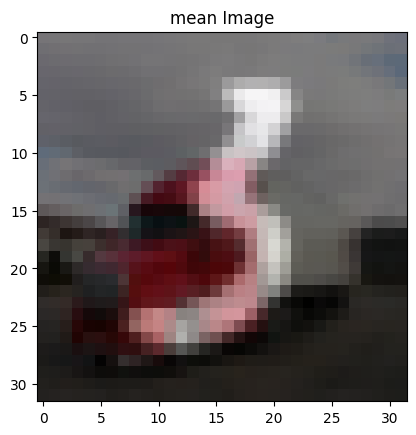

In [219]:
plt.title('mean Image')
plt.imshow(mean_image_np)
plt.show()

In [220]:
X_train = mean_image 

num_repeats = 100 
X_train = X_train.repeat(num_repeats, 1, 1, 1)

In [221]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        # Decoder 1
        self.decoder1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
        # Decoder 2
        self.decoder2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded1 = self.decoder1(encoded)
        decoded2 = self.decoder2(encoded)
        return decoded1, decoded2

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [206]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]          18,464
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]           4,624
              ReLU-8           [-1, 16, 56, 56]               0
         MaxPool2d-9           [-1, 16, 28, 28]               0
           Conv2d-10           [-1, 16, 28, 28]           2,320
             ReLU-11           [-1, 16, 28, 28]               0
         Upsample-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]           4,640
             ReLU-14           [-1, 32,

In [222]:
num_epochs = 20
batch_size = 2

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size]
        optimizer.zero_grad()
        outputs1, outputs2 = model(inputs)
        loss1 = criterion(outputs1, mnist_image)
        loss2 = criterion(outputs2, cifar_image)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished.')


c:\Users\Rina\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 3, 32, 32])) that is different to the input size (torch.Size([2, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 0.1060
Epoch [2/20], Loss: 0.0974
Epoch [3/20], Loss: 0.0949
Epoch [4/20], Loss: 0.0937
Epoch [5/20], Loss: 0.0932
Epoch [6/20], Loss: 0.0927
Epoch [7/20], Loss: 0.0924
Epoch [8/20], Loss: 0.0921
Epoch [9/20], Loss: 0.0919
Epoch [10/20], Loss: 0.0919
Epoch [11/20], Loss: 0.0918
Epoch [12/20], Loss: 0.0916
Epoch [13/20], Loss: 0.0916
Epoch [14/20], Loss: 0.0915
Epoch [15/20], Loss: 0.0914
Epoch [16/20], Loss: 0.0922
Epoch [17/20], Loss: 0.0913
Epoch [18/20], Loss: 0.0913
Epoch [19/20], Loss: 0.0913
Epoch [20/20], Loss: 0.0914
Training finished.


torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


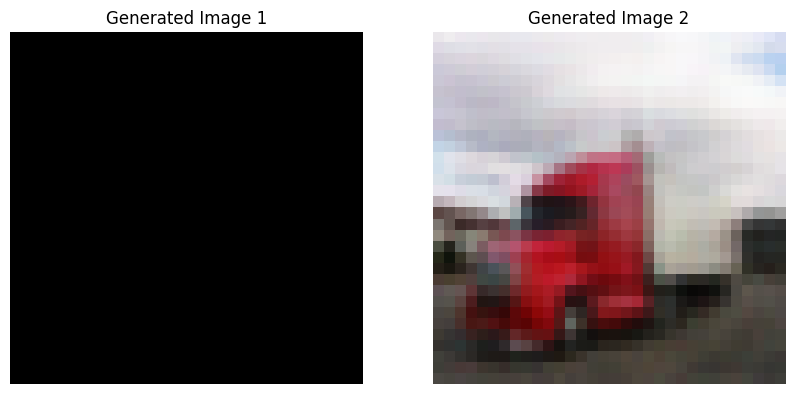

In [223]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

print(mean_image.shape)
if mean_image.dim() == 4:
    mean_image = mean_image.squeeze(0) 


mean_image_batch = mean_image.unsqueeze(0)
print(mean_image_batch.shape)


model.eval()
with torch.no_grad():
    generated_image1, generated_image2 = model(mean_image_batch)

generated_image1 = transforms.ToPILImage()(generated_image1.squeeze(0))
generated_image2 = transforms.ToPILImage()(generated_image2.squeeze(0))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(generated_image1)
axes[0].set_title('Generated Image 1')
axes[0].axis('off')

axes[1].imshow(generated_image2)
axes[1].set_title('Generated Image 2')
axes[1].axis('off')

plt.show()


In [224]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

mean_image_batch = mean_image.unsqueeze(0) 
model.eval()
with torch.no_grad():
    generated_image1, generated_image2 = model(mean_image_batch)


generated_image1_np = generated_image1.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_image2_np = generated_image2.squeeze(0).permute(1, 2, 0).cpu().numpy()
original_image1_np = mnist_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
original_image2_np = cifar_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

data_range = original_image1_np.max() - original_image1_np.min()

win_size = 3 

ssim1 = ssim(original_image1_np, generated_image1_np, win_size=win_size, data_range=data_range, multichannel=True)
ssim2 = ssim(original_image2_np, generated_image2_np, win_size=win_size, data_range=data_range, multichannel=True)
psnr1 = psnr(original_image1_np, generated_image1_np, data_range=data_range)
psnr2 = psnr(original_image2_np, generated_image2_np, data_range=data_range)

print(f"SSIM1: {ssim1}, SSIM2: {ssim2}")
print(f"PSNR1: {psnr1}, PSNR2: {psnr2}")

SSIM1: 0.6782892674979256, SSIM2: 0.9649068710539076
PSNR1: 10.389025597308487, PSNR2: 34.315770043653934
